
### 1. Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses relacionadas.

Durante a fase de tratamento de dados encontrei alguns problemas no dataset como valores nulos e tipos de dados inconsistentes, tornando a primeira tarefa a limpeza e reescrita de dados numéricos.

Durante a fase de criação de hipóteses utilizei primeiro o formato tabular para anotar algumas ideias e aplicar usando gráficos após garantir a consistência dos dados. 

### 2.a Qual filme você indicaria para alguém que não conhece.

Um filme aclamado pelo público tem mais chances de cativar uma pessoa desconhecida. No exemplo do filme The Godfather que tem o conjunto de Nota do IMDB, Meta Score e número de votos acima da média, acredito que seja a opção mais segura. 

### 2.b Quais os fatores relacionados com a expectativa de faturamento de um filme.

Com base no heatmap e em gráficos de correlação podemos afirmar que o número de votos, gêneros específicos como ação, aventura, sci-fi e animações tendem a ter faturamentos médios mais altos. Existem atores e diretores associados a mais filmes com alto faturamento o que também pode indicar algo de forma mais complexa.

Mesmo com uma correlação mais baixa, a nota do IMDB e o Meta Score podem ser indicadores muito influentes. a Nota do IMDB pode ter uma correlação negativa e fraca, porém muitos filmes com aclamação crítica não tem um sucesso de bilheteria, e da mesma forma filmes que não agradaram tanto os críticos fizeram uma bilheteria muito boa.

### 2.c

Infelizmente não consegui implementar a parte de processamento de linguagem natural e não consegui responder a questão.

### 3. Explique como você faria a previsão da nota do IMDB

Escolhi as colunas de número de votos, meta score, tempo de tela e faturamento por serem variáveis de correlação positiva com a nota do IMDB.
Como o problema é de regressão, utilizei o modelo Random Forest por sua alta precisão, gerenciamento de features e pela sensibilidade com outliers. Como precisamos colocar a mediana para preencher muitos dados um modelo que é menos sensível aos outliers é a melhor opção.


### 4. Supondo a nota do IMDB de um filme.
A resolução da questão 4 está no final do notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [8]:
#Import da base de dados.
db = "db\desafio_indicium_imdb.csv"
df = pd.read_csv(db, index_col=0)

In [9]:
df.info()
#Aqui encontramos muitos valores nulos e inconsistências na formatação dos dados, como em Runtime, Released_Year e Gross (Object)

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 124.9+ KB


In [10]:
df.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


Nessa primeira análise conseguimos perceber alguns valores nulos em Meta Score, Certificate e Gross. Alguns desses valores podem atrapalhar futuramente na implementação de um modelo de machine learning. Para solucionar vamos ir um pouco mais afundo nos tipos de dados e depois aplicar as devidas correções para deixar o caminho aberto para a implementação do modelo.
Além dos valores nulos também precisamos atualizar alguns tipos de variáveis para tratar valores.

Para o Certificate encontramos um problema, definir qual a categoria dos filmes que estão com as categorias ausentes e para facilitar o processo utilizarei Unknown para classificar os filmes.
Caso em algum momento encontre alguma correlação dos Unknowns com alguma variável volto aqui e faço alterações entre Unknown / U / Unrated.

Optei pelo uso da mediana ao invés da média para preencher valores ausentes por conter valores menos afetados pelos outliers.

In [11]:
df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)
df['Gross'] = df['Gross'].str.replace(',', '').astype(float)
df['Certificate'] = df['Certificate'].fillna('Unknown')
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].median())
df['Gross'] = df['Gross'].fillna(df['Gross'].median())
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce').astype('Int64')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  998 non-null    Int64  
 2   Certificate    999 non-null    object 
 3   Runtime        999 non-null    int64  
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     999 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          999 non-null    float64
dtypes: Int64(1), float64(3), int64(2), object(9)
memory usage: 125.9+ KB


In [13]:
#Analisando o número de votos e correlacionando com score.
df_votes = df.sort_values(by='No_of_Votes', ascending=False)
df_votes.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
2,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
8,Inception,2010,UA,148,"Action, Adventure, Sci-Fi",8.8,A thief who steals corporate secrets through t...,74.0,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Elliot Page,Ken Watanabe,2067042,292576195.0
9,Fight Club,1999,A,139,Drama,8.8,An insomniac office worker and a devil-may-car...,66.0,David Fincher,Brad Pitt,Edward Norton,Meat Loaf,Zach Grenier,1854740,37030102.0
6,Pulp Fiction,1994,A,154,"Crime, Drama",8.9,"The lives of two mob hitmen, a boxer, a gangst...",94.0,Quentin Tarantino,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,1826188,107928762.0
11,Forrest Gump,1994,UA,142,"Drama, Romance",8.8,"The presidencies of Kennedy and Johnson, the e...",82.0,Robert Zemeckis,Tom Hanks,Robin Wright,Gary Sinise,Sally Field,1809221,330252182.0


### Visualizações
Com os valores preenchidos e os tipos de dados corrigidos, podemos trabalhar com as visualizações para explorar mais as nossas análises e embasar melhor nossas hipóteses.

### Análise

A distribuição de notas indica uma forte aglomeração entre 7.6 e 8.4, deixando mais evidente exclusividades em filmes com notas mais altas e trazendo a oportunidade de trabalhar melhor com similaridades entre os filmes mais aclamados.

A frequência de diretores em projetos não diz muito sobre a performance em questão de bilheteria e os dados acabam sendo inconclusivos nesta questão.

*Drama, comédia e crime* são os temas mais frequentes na lista, mas são os temas mais rentáveis? Vou explorar isso nas próximas etapas.

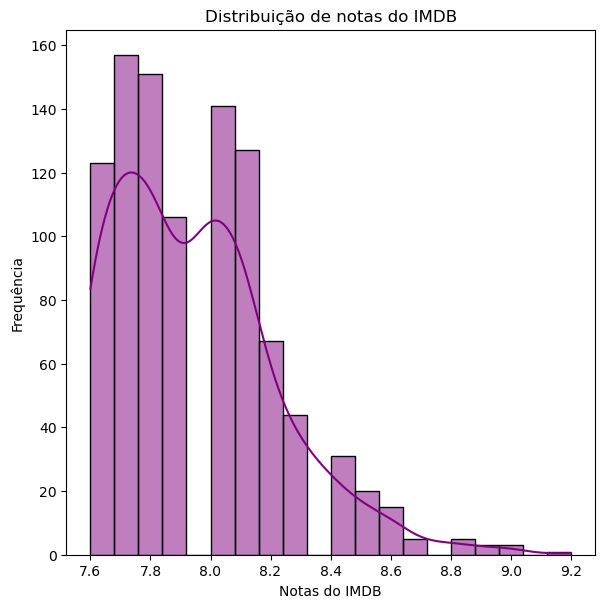

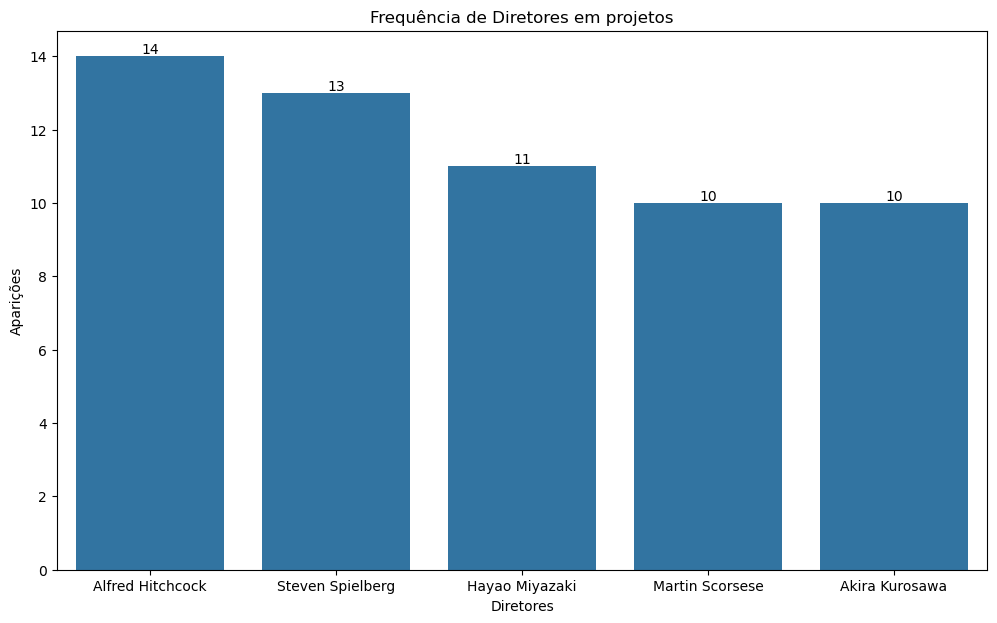

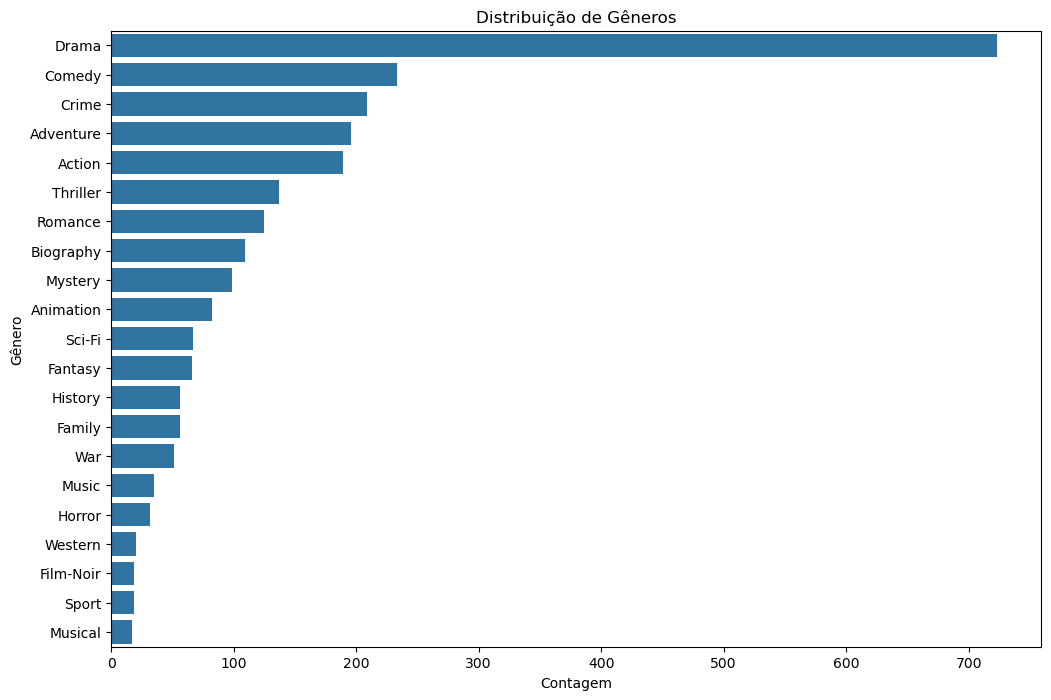

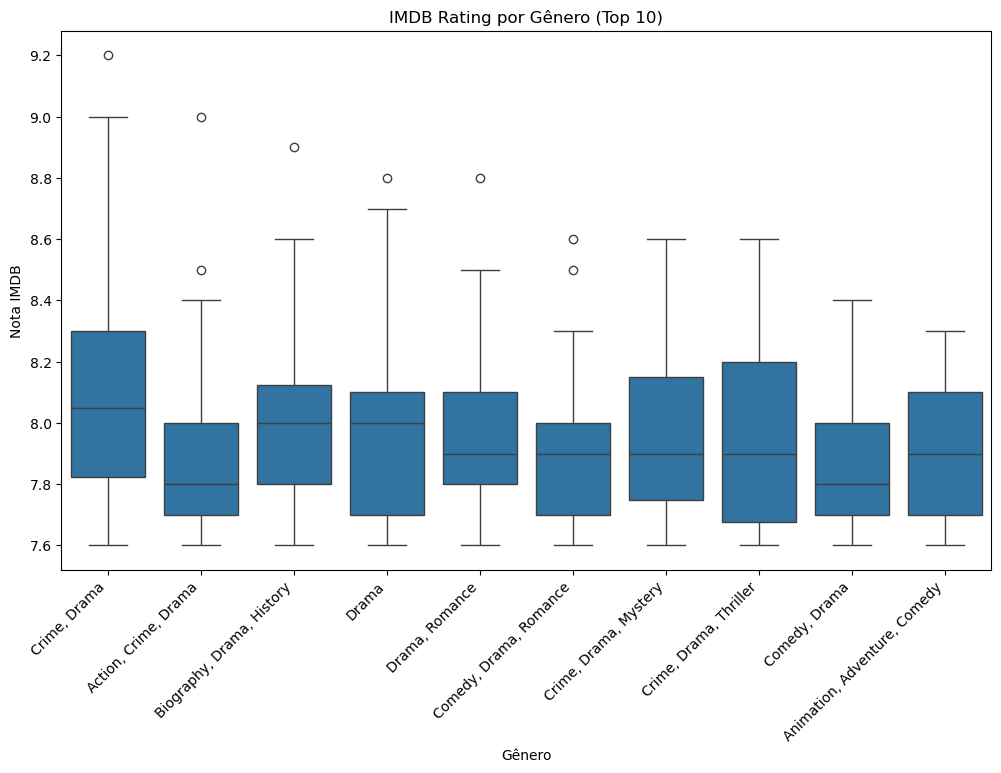

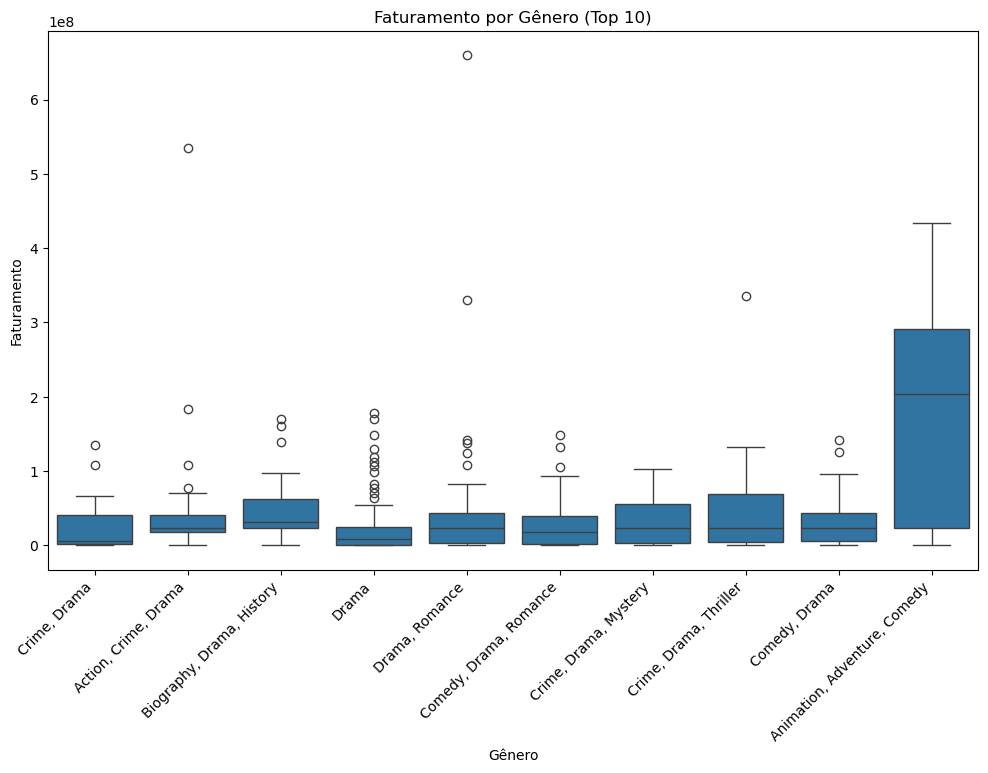

In [16]:
plt.figure (figsize=(15, 15))
plt.subplot(2, 2, 1)
sns.histplot(df['IMDB_Rating'], kde=True, color='purple')
plt.title("Distribuição de notas do IMDB")
plt.xlabel("Notas do IMDB")
plt.ylabel("Frequência")


plt.figure(figsize=(12, 7))
top_5_diretores = df['Director'].value_counts().head(5)
ax = sns.barplot(x=top_5_diretores.index, y=top_5_diretores.values)
ax.bar_label(ax.containers[0])
plt.title("Frequência de Diretores em projetos")
plt.xlabel('Diretores')
plt.ylabel('Aparições')


genres = df['Genre'].str.split(", ").explode()
plt.figure(figsize=(12, 8))
sns.countplot(y=genres, order=genres.value_counts().index)
plt.title("Distribuição de Gêneros")
plt.xlabel("Contagem")
plt.ylabel("Gênero")


top_genres = df['Genre'].value_counts().head(10).index
plt.figure(figsize=(12, 7))
sns.boxplot(x='Genre', y='IMDB_Rating', data=df[df['Genre'].isin(top_genres)])
plt.title('IMDB Rating por Gênero (Top 10)')
plt.xlabel('Gênero')
plt.ylabel('Nota IMDB')
plt.xticks(rotation=45, ha='right')


plt.figure(figsize=(12, 7))
sns.boxplot(x='Genre', y='Gross', data=df[df['Genre'].isin(top_genres)])
plt.title('Faturamento por Gênero (Top 10)')
plt.xlabel('Gênero')
plt.ylabel('Faturamento')
plt.xticks(rotation=45, ha='right')


plt.figure(figsize=(12, 6))
sns.countplot(x='Released_Year', data=df, order=df['Released_Year'].value_counts().index)
plt.title('Número de Filmes Lançados por Ano')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=90, fontsize=8)
plt.close()

Text(0.5, 1.0, 'Mapa de Calor')

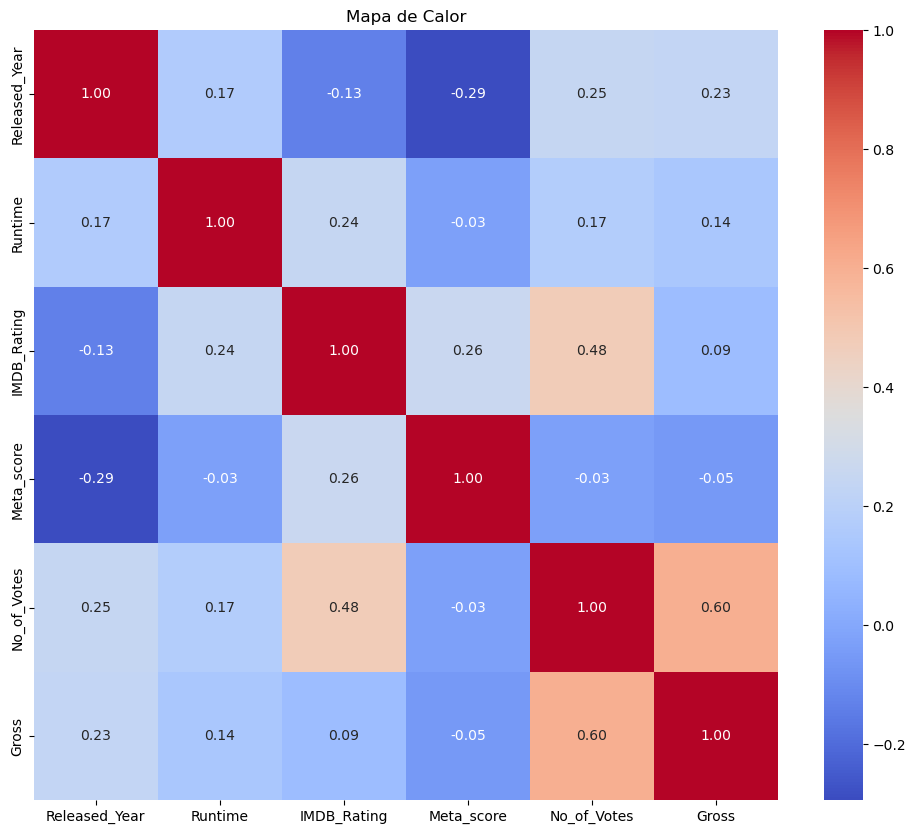

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Calor")

### Questão 2.B
A correlação forte de Número de votos e faturamento indica que a popularidade e engajamento do público são um forte indicador do alto faturamento.
Embora outras correlações tenham menos força, ainda existem algumas correlações de valores positivos que podem ajudar a indicar um fator para alto faturamento.

Como o caso da correlação positiva (e fraca) as notas do IMDB que não condizem tanto com o faturamento de filmes, mas podem influenciar na pesquisa quando implementada uma análise mais profunda sobre os sucessos de bilheteria e o contexto histórico.



Text(0, 0.5, 'Notas do IMDB')

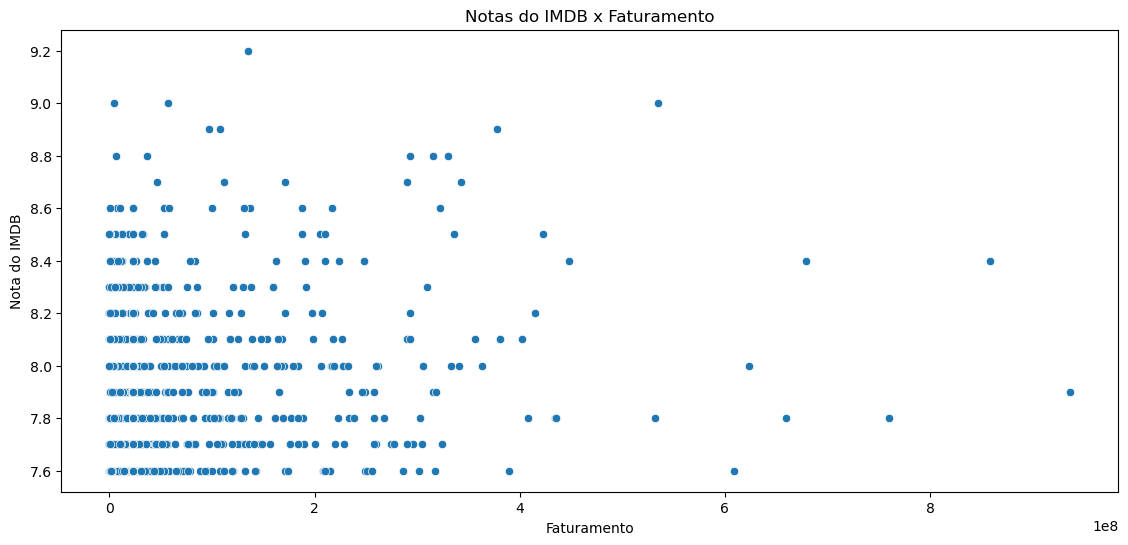

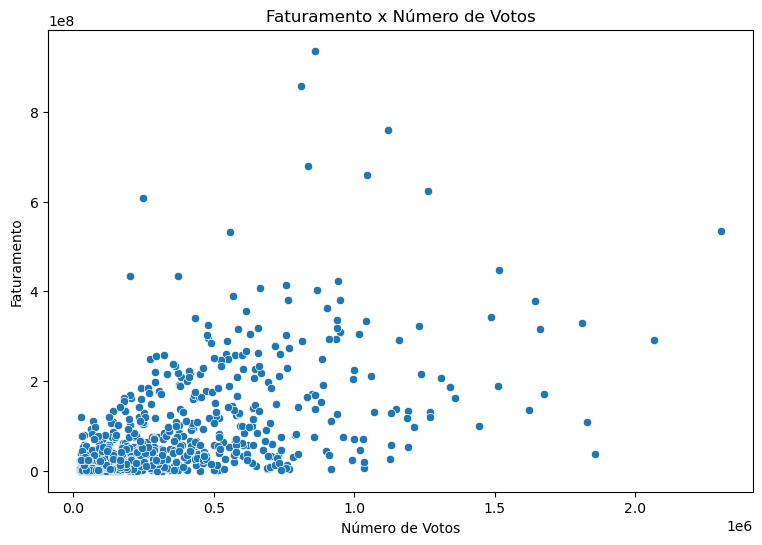

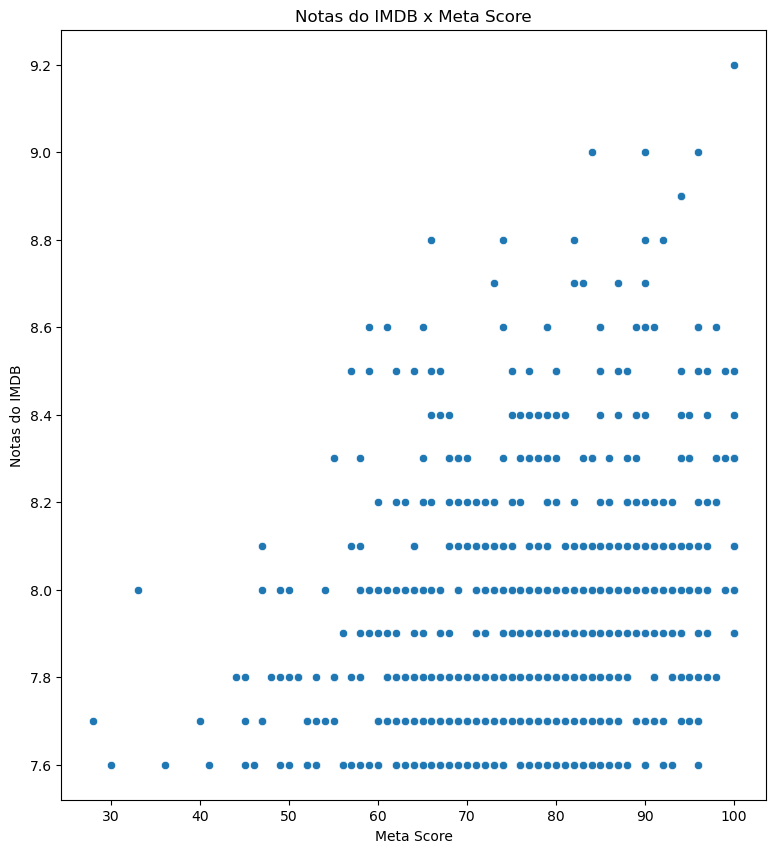

In [18]:
plt.figure(figsize=(30, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Gross', y='IMDB_Rating', data=df)
plt.title('Notas do IMDB x Faturamento')
plt.xlabel('Faturamento')
plt.ylabel('Nota do IMDB')

plt.figure(figsize=(20,6))
plt.subplot(1, 2, 2)
sns.scatterplot(x="No_of_Votes", y="Gross", data=df)
plt.title("Faturamento x Número de Votos")
plt.xlabel("Número de Votos")
plt.ylabel("Faturamento")

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 2)
sns.scatterplot(x="Meta_score", y="IMDB_Rating", data=df)
plt.title("Notas do IMDB x Meta Score")
plt.xlabel("Meta Score")
plt.ylabel("Notas do IMDB")



### Prevendo a nota do IMDB
A primeira etapa é a seleção de variáveis que utilizaremos para prever a nota
Vamos selecionar as variáveis de *número de votos, meta score, runtime e gross* por sua correlação positiva.
Como precisamos prever um valor contínuo com variação de 1 a 10 a minha primeira pedida é um algoritmo de regressão.

In [19]:
#Definindo feature e target (X e y)
X = df[["No_of_Votes", "Meta_score", "Runtime", "Gross"]]
y = df[["IMDB_Rating"]]

#Dividindo em treino e teste e testando modelos de regressão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Regressao Linear": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R2": r2}

report_content = f""" {results["Regressao Linear"]["RMSE"]} | {results["Regressao Linear"]["R2"]}
{results["Decision Tree"]["RMSE"]} | {results["Decision Tree"]["R2"]}
{results["Random Forest"]["RMSE"]} | {results["Random Forest"]["R2"]}
"""
with open("report_compara_modelos.md", "w") as f:
    f.write(report_content)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### Comparação de Modelos de Regressão para Previsão da Nota IMDB

Para avaliar a robustez da previsão da nota IMDB, treinamos e comparamos três modelos de regressão:
Regressão Linear, Decision Tree Regressor e Random Forest Regressor.

**Métricas de Avaliação:**
- **RMSE (Root Mean Squared Error):** Mede a magnitude média dos erros do modelo. Valores menores indicam melhor ajuste.
- **R2 Score (Coeficiente de Determinação):** Indica a proporção da variância na variável dependente que é previsível a partir das variáveis independentes. Valores mais próximos de 1 indicam melhor ajuste.

```
|||       RMSE       |       R2        |||
0.2259186051812706   |  0.22248467236836866 > Regressão Linear
0.24647515087732474  |  0.0745536530375972 > Árvore de Decisão
0.1991244209031125   |  0.39597625068551734 > Random Forest
```

Respondendo a pergunta, o Random Forest se mostrou o modelo mais adequado para a previsão da nota, performando muito melhor que os outros modelos.

Agora vamos para a última etapa, a predição para o filme *Shawshank Redemption*

In [20]:
#Utilizaremos o random forest para testar.
final_model = RandomForestRegressor(random_state=42)
final_model.fit(X_train, y_train)

#Dados do filme necessários para a predição
shawshank_data = {
    'No_of_Votes': [2343110],
    'Meta_score': [80.0],
    'Runtime': [142],
    'Gross': [28341469.0]
}

shawshank_df = pd.DataFrame(shawshank_data)

predicted_rating = final_model.predict(shawshank_df)

joblib.dump(final_model, 'predict_imdb_model.pkl')

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


['predict_imdb_model.pkl']

In [21]:
print(f"A nota prevista para o filme é: {predicted_rating[0]:.2f}")

A nota prevista para o filme é: 8.76


#### Como apoio na resolução do desafio usei os livros Python Data Science Handbook, Data Science from Scratch e Machine Learning With Python Cookbook da O'reilly. Para a definição do modelo de ML pesquisei e encontrei esse guia da própria documentação do ScikitLearn https://scikit-learn.org/stable/machine_learning_map.html